# Feature Correlaiton Notebook

In this notebook I want to look at two things:
1) Sort the data by MLD (and maybe latitude?) and see how the correlation changes along these divisions.
2) Sum the absolute value of correlation across all 4 inputs and see how this "correlation profile" compares to the "MSE profile" that comes out of the model.

What I expect is that shallower MLD and lower latitude will have higher correlation. I also imagine that regions of the profile with high correlation will have low MSE.

The goal of this is to try to address "explainability" of the model: it's difficult to dive into the black box of neural networks, however we can at least understand the data we're working with beter. Hopefully this notebook starts to address this.

## From the original starter notebook

In [2]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests

from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
#import lib.func_file as ff
#from lib.visual_figure4 import performance_sigma_point
#from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan


In [4]:
# Open the dataset from Sane et al. 2023, here stored on the cloud, accessible on LEAP-Pangeo
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# this function calculates the coriolis parameter from input latitude 
# 2*Omega*sin(lat), where Omega is the Earth's rotation in 1/s
def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 

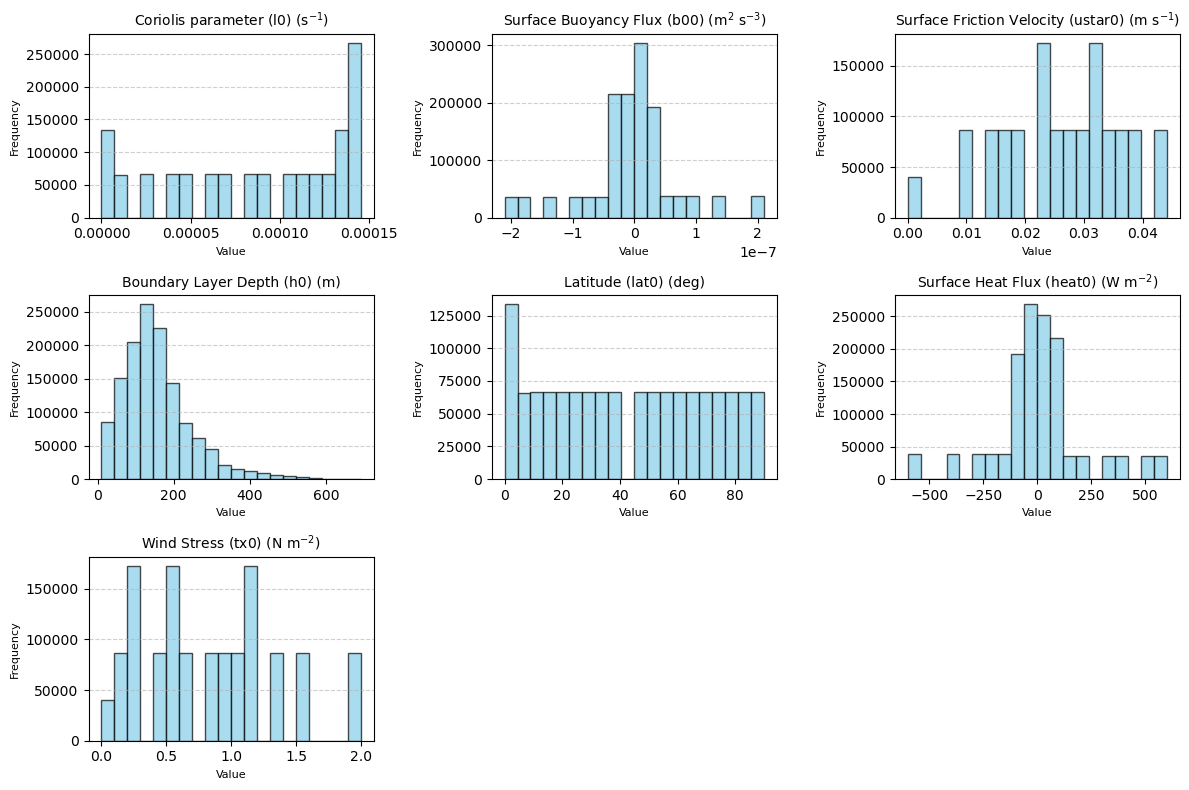

In [5]:
variables = {
    "Coriolis parameter (l0) (s$^{-1}$)": l0.values.flatten(),
    "Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": b00.values.flatten(),
    "Surface Friction Velocity (ustar0) (m s$^{-1}$)": ustar0.values.flatten(),
    "Boundary Layer Depth (h0) (m)": h0.values.flatten(),
    "Latitude (lat0) (deg)": lat0.values.flatten(),
    "Surface Heat Flux (heat0) (W m$^{-2}$)": heat0.values.flatten(),
    "Wind Stress (tx0) (N m$^{-2}$)": tx0.values.flatten(),
}

# Plot histograms for the input variables
plt.figure(figsize=(12, 8))
for i, (name, data) in enumerate(variables.items()):
    plt.subplot(3, 3, i + 1)
    plt.hist(data, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title(name, fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

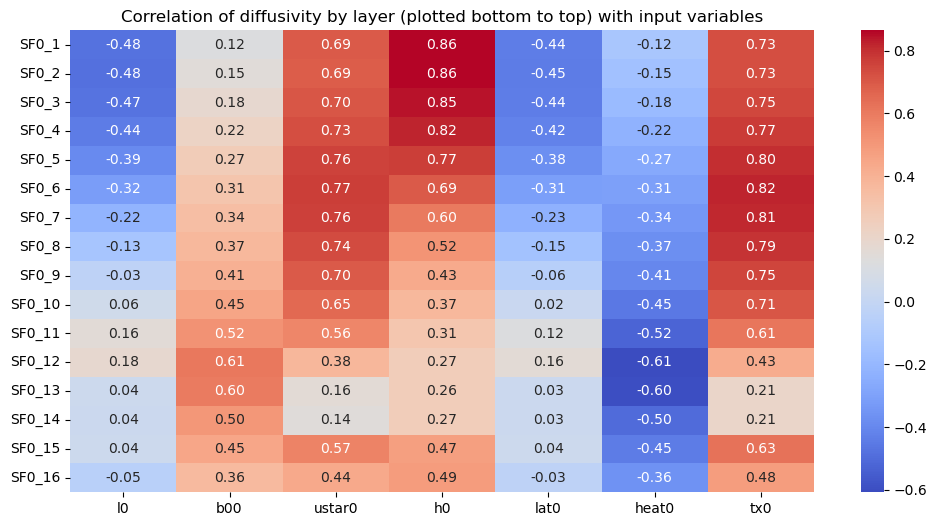

In [6]:
# How are the input data correlated to diffusivity at each level? Make a plot to consider this
data = {
    "l0": l0.values.flatten(),
    "b00": b00.values.flatten(),
    "ustar0": ustar0.values.flatten(),
    "h0": h0.values.flatten(),
    "lat0": lat0.values.flatten(),
    "heat0": heat0.values.flatten(),
    "tx0": tx0.values.flatten(),
}

for i in range(16):
    data[f"SF0_{i+1}"] = SF0[:, 16-i-1].values.flatten()

df = pd.DataFrame(data)

correlation_matrix = df.corr()

sf0_correlation = correlation_matrix.loc["SF0_1":"SF0_16", ["l0", "b00", "ustar0", "h0", "lat0", "heat0", "tx0"]]

plt.figure(figsize=(12, 6))
sns.heatmap(sf0_correlation, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation of diffusivity by layer (plotted bottom to top) with input variables")
plt.show()

## Making divisions based on MLD

In [29]:
depth = 200

d_shal = d.where(d.h.compute() < depth, drop=True)
d_deep = d.where(d.h.compute() > depth, drop=True)

In [30]:
l0_shal    =corio(d_shal['l'][:])
b00_shal   =d_shal['b0'][:]
ustar0_shal=d_shal['ustar'][:]
h0_shal    =d_shal['h'][:]
lat0_shal  =d_shal['lat'][:]
heat0_shal =d_shal['heat'][:]
tx0_shal   =d_shal['tx'][:] 
tx0_shal   =np.round(tx0_shal,2)
SF0_shal   =d_shal['SF'][:] 

l0_deep    =corio(d_deep['l'][:])
b00_deep   =d_deep['b0'][:]
ustar0_deep=d_deep['ustar'][:]
h0_deep    =d_deep['h'][:]
lat0_deep  =d_deep['lat'][:]
heat0_deep =d_deep['heat'][:]
tx0_deep   =d_deep['tx'][:] 
tx0_deep   =np.round(tx0_deep,2)
SF0_deep   =d_deep['SF'][:] 

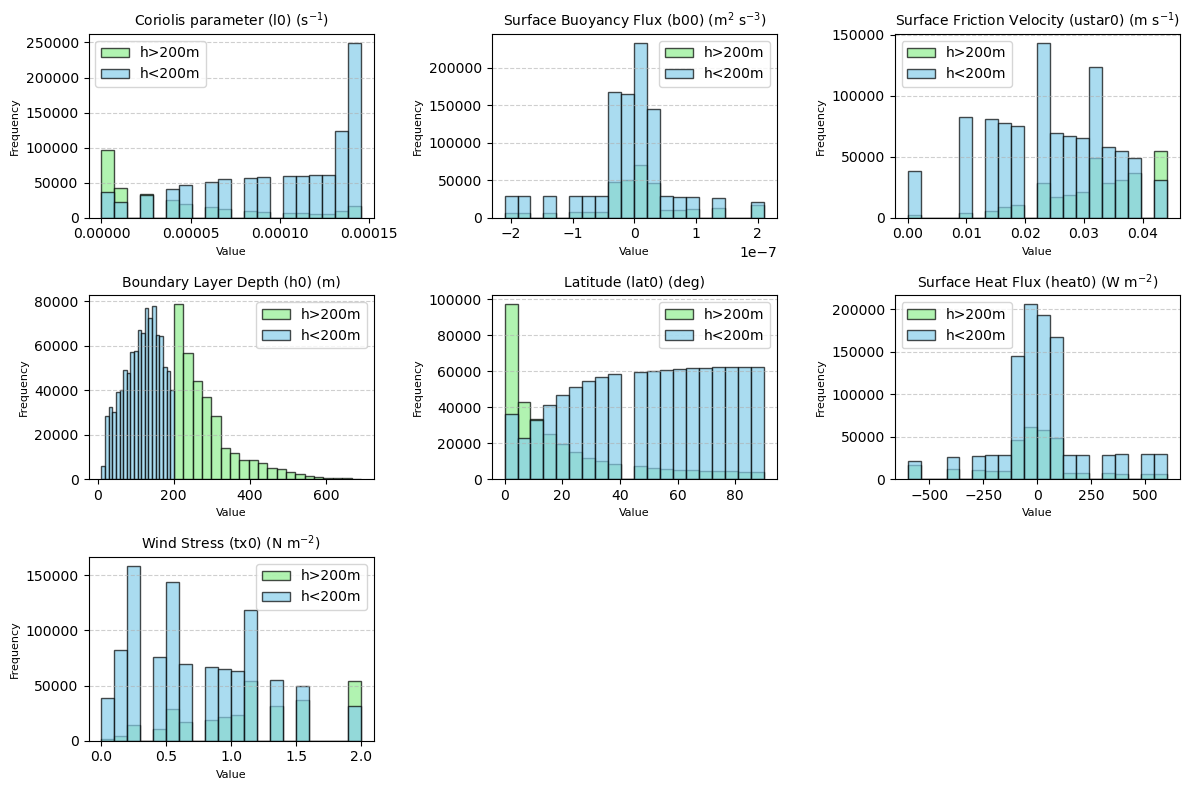

In [31]:
variables_shal = {
    "Coriolis parameter (l0) (s$^{-1}$)": l0_shal.values.flatten(),
    "Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": b00_shal.values.flatten(),
    "Surface Friction Velocity (ustar0) (m s$^{-1}$)": ustar0_shal.values.flatten(),
    "Boundary Layer Depth (h0) (m)": h0_shal.values.flatten(),
    "Latitude (lat0) (deg)": lat0_shal.values.flatten(),
    "Surface Heat Flux (heat0) (W m$^{-2}$)": heat0_shal.values.flatten(),
    "Wind Stress (tx0) (N m$^{-2}$)": tx0_shal.values.flatten(),
}

variables_deep = {
    "Coriolis parameter (l0) (s$^{-1}$)": l0_deep.values.flatten(),
    "Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": b00_deep.values.flatten(),
    "Surface Friction Velocity (ustar0) (m s$^{-1}$)": ustar0_deep.values.flatten(),
    "Boundary Layer Depth (h0) (m)": h0_deep.values.flatten(),
    "Latitude (lat0) (deg)": lat0_deep.values.flatten(),
    "Surface Heat Flux (heat0) (W m$^{-2}$)": heat0_deep.values.flatten(),
    "Wind Stress (tx0) (N m$^{-2}$)": tx0_deep.values.flatten(),
}

# Plot histograms for the input variables
plt.figure(figsize=(12, 8))
for i, (name, data) in enumerate(variables_deep.items()):
    plt.subplot(3, 3, i + 1)
    plt.hist(data, bins=20, color="lightgreen", edgecolor="black", alpha=0.7, label='h>{}m'.format(depth))
    plt.title(name, fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.legend()
    
for i, (name, data) in enumerate(variables_shal.items()):
    plt.subplot(3, 3, i + 1)
    plt.hist(data, bins=20, color="skyblue", edgecolor="black", alpha=0.7, label='h<{}m'.format(depth))
    plt.title(name, fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.legend()
    
plt.tight_layout()
plt.show()

In [32]:
# How are the input data correlated to diffusivity at each level? Make a plot to consider this
data_shal = {
    "l0": l0_shal.values.flatten(),
    "b00": b00_shal.values.flatten(),
    "ustar0": ustar0_shal.values.flatten(),
    "h0": h0_shal.values.flatten(),
    "lat0": lat0_shal.values.flatten(),
    "heat0": heat0_shal.values.flatten(),
    "tx0": tx0_shal.values.flatten(),
}

for i in range(16):
    data_shal[f"SF0_{i+1}"] = SF0_shal[:, 16-i-1].values.flatten()

df_shal = pd.DataFrame(data_shal)
correlation_matrix_shal = df_shal.corr()
sf0_correlation_shal = correlation_matrix_shal.loc["SF0_1":"SF0_16", ["l0", "b00", "ustar0", "h0"]]

data_deep = {
    "l0": l0_deep.values.flatten(),
    "b00": b00_deep.values.flatten(),
    "ustar0": ustar0_deep.values.flatten(),
    "h0": h0_deep.values.flatten(),
    "lat0": lat0_deep.values.flatten(),
    "heat0": heat0_deep.values.flatten(),
    "tx0": tx0_deep.values.flatten(),
}

for i in range(16):
    data_deep[f"SF0_{i+1}"] = SF0_deep[:, 16-i-1].values.flatten()

df_deep = pd.DataFrame(data_deep)
correlation_matrix_deep = df_deep.corr()
sf0_correlation_deep = correlation_matrix_deep.loc["SF0_1":"SF0_16", ["l0", "b00", "ustar0", "h0"]]

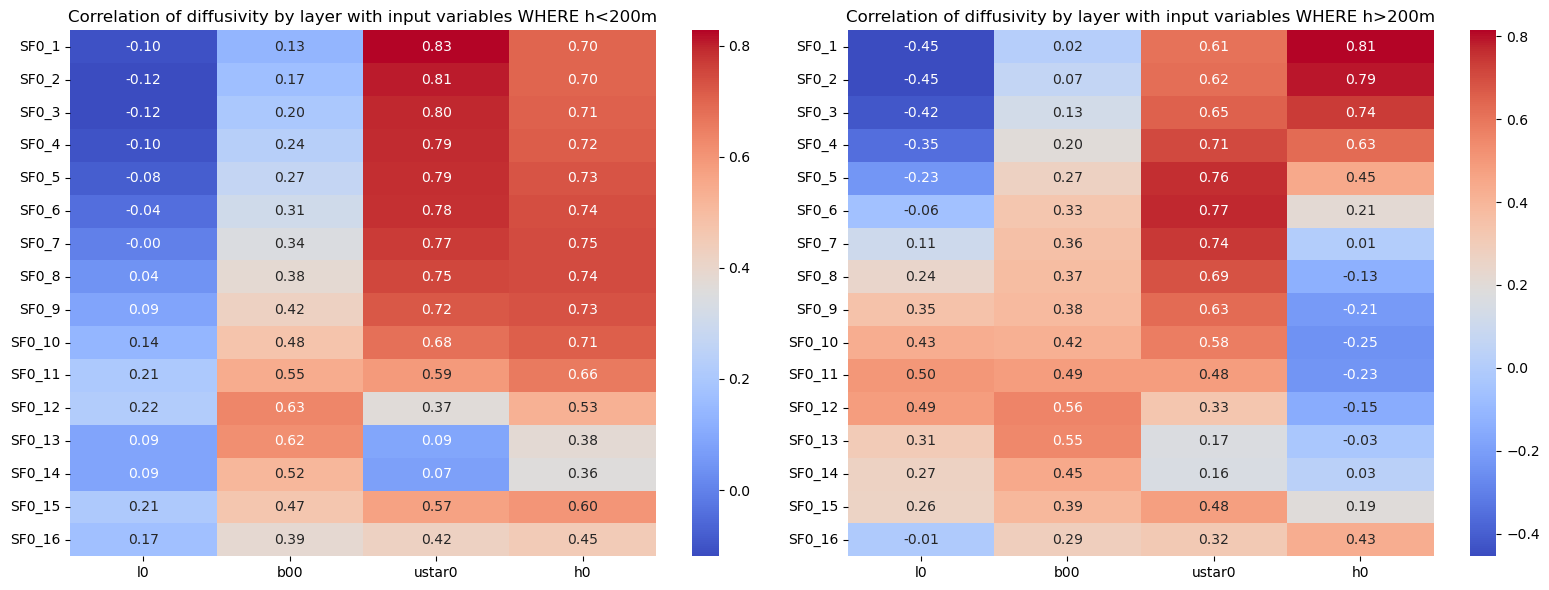

In [33]:
# Create a figure and subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Adjust `figsize` as needed for better visualization

# First heatmap
sns.heatmap(sf0_correlation_shal, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, ax=axs[0])
axs[0].set_title("Correlation of diffusivity by layer with input variables WHERE h<{}m".format(depth))

# Second heatmap
sns.heatmap(sf0_correlation_deep, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, ax=axs[1])
axs[1].set_title("Correlation of diffusivity by layer with input variables WHERE h>{}m".format(depth))

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [34]:
shal_correlation_prof = sf0_correlation_shal.abs().sum(axis=1)
deep_correlation_prof = sf0_correlation_deep.abs().sum(axis=1)
y = np.arange(1,17)

Text(0.5, 1.0, 'Correlation of diffusivity by layer, summed over the absolute value of all input variables')

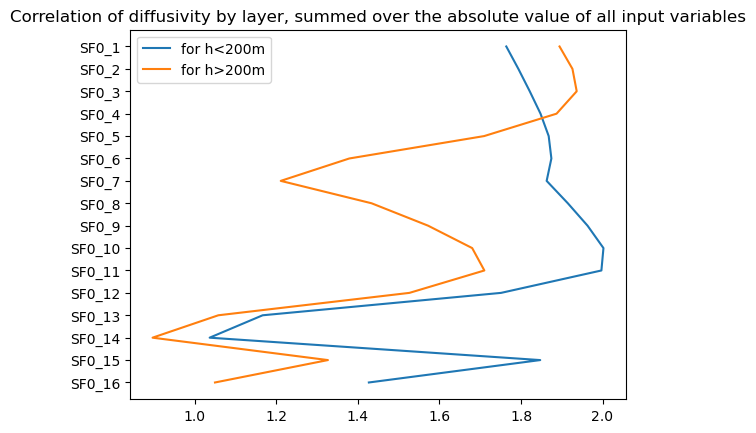

In [35]:
plt.plot(shal_correlation_prof, y, label=f"for h<{depth}m")
plt.plot(deep_correlation_prof, y, label=f"for h>{depth}m")
plt.gca().invert_yaxis()
plt.legend()
plt.yticks(ticks=np.arange(1,17,1),labels=['SF0_1','SF0_2','SF0_3','SF0_4','SF0_5','SF0_6','SF0_7','SF0_8','SF0_9','SF0_10','SF0_11','SF0_12','SF0_13','SF0_14','SF0_15','SF0_16']);
plt.title('Correlation of diffusivity by layer, summed over the absolute value of all input variables')

## Function for making divisions by MLD depth

In [71]:
def correlation_by_depth(depth_min, depth_max):
    d_depth = d.where((d.h.compute() < depth_max) & (d.h.compute() > depth_min), drop=True)
    l0_depth    =corio(d_depth['l'][:])
    b00_depth   =d_depth['b0'][:]
    ustar0_depth=d_depth['ustar'][:]
    h0_depth    =d_depth['h'][:]
    lat0_depth  =d_depth['lat'][:]
    heat0_depth =d_depth['heat'][:]
    tx0_depth   =d_depth['tx'][:] 
    tx0_depth   =np.round(tx0_depth,2)
    SF0_depth   =d_depth['SF'][:] 
    
    data_depth = {
        "l0": l0_depth.values.flatten(),
        "b00": b00_depth.values.flatten(),
        "ustar0": ustar0_depth.values.flatten(),
        "h0": h0_depth.values.flatten(),
    }
    
    for i in range(16):
        data_depth[f"SF0_{i+1}"] = SF0_depth[:, 16-i-1].values.flatten()
    
    df_depth = pd.DataFrame(data_depth)
    correlation_matrix_depth = df_depth.corr()
    sf0_correlation_depth = correlation_matrix_depth.loc["SF0_1":"SF0_16", ["l0", "b00", "ustar0", "h0"]]

    return sf0_correlation_depth

In [72]:
corr_25  = correlation_by_depth(0,25)
print('Completed correlation for h<25m')
corr_50  = correlation_by_depth(0,50)
print('Completed correlation for h<50m')
corr_75  = correlation_by_depth(0,75)
print('Completed correlation for h<75m')
corr_100 = correlation_by_depth(0,100)
print('Completed correlation for h<100m')
corr_150 = correlation_by_depth(0,150)
print('Completed correlation for h<150m')
corr_200 = correlation_by_depth(0,200)
print('Completed correlation for h<200m')
corr_250 = correlation_by_depth(0,250)
print('Completed correlation for h<250m')
corr_300 = correlation_by_depth(0,300)
print('Completed correlation for h<300m')
corr_400 = correlation_by_depth(0,400)
print('Completed correlation for h<400m')
corr_500 = correlation_by_depth(0,500)
print('Completed correlation for h<500m')
corr_600 = correlation_by_depth(0,600)
print('Completed correlation for h<600m')
corr_700 = correlation_by_depth(0,700)
print('Completed correlation for h<700m')

Completed correlation for h<25m
Completed correlation for h<50m
Completed correlation for h<75m
Completed correlation for h<100m
Completed correlation for h<150m
Completed correlation for h<200m
Completed correlation for h<250m
Completed correlation for h<300m
Completed correlation for h<400m
Completed correlation for h<500m
Completed correlation for h<600m
Completed correlation for h<700m


In [73]:
corr_25_prof = corr_25.abs().sum(axis=1)
corr_50_prof = corr_50.abs().sum(axis=1)
corr_75_prof = corr_75.abs().sum(axis=1)
corr_100_prof = corr_100.abs().sum(axis=1)
corr_150_prof = corr_150.abs().sum(axis=1)
corr_200_prof = corr_200.abs().sum(axis=1)
corr_250_prof = corr_250.abs().sum(axis=1)
corr_300_prof = corr_300.abs().sum(axis=1)
corr_400_prof = corr_400.abs().sum(axis=1)
corr_500_prof = corr_500.abs().sum(axis=1)
corr_600_prof = corr_600.abs().sum(axis=1)
corr_700_prof = corr_700.abs().sum(axis=1)

In [86]:
colors = plt.cm.summer_r(np.linspace(0,1,12))

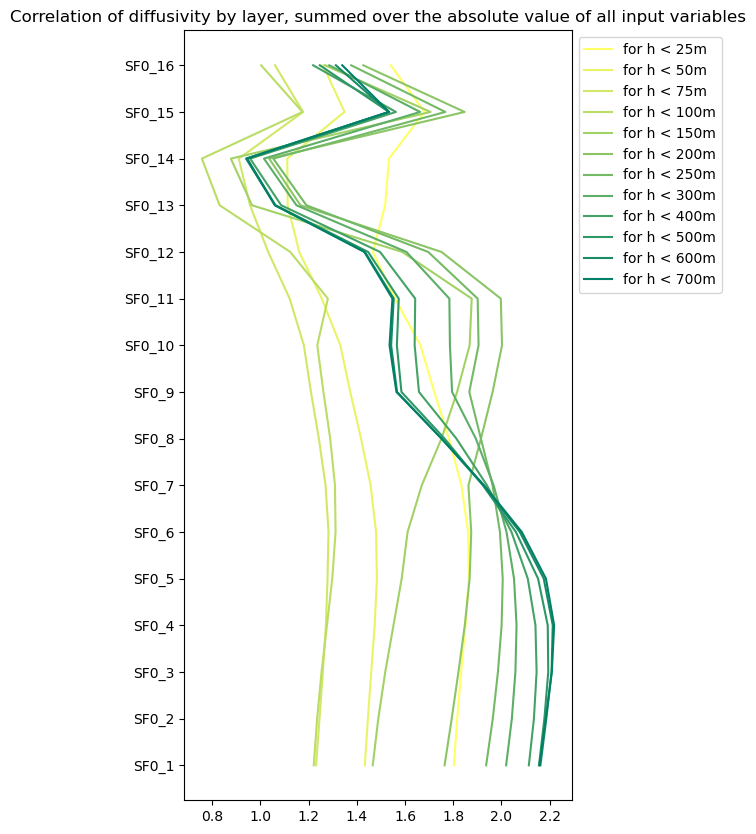

In [87]:
plt.figure(figsize=(5,10))
plt.plot(corr_25_prof,  y, label=f"for h < 25m",  color=colors[0])
plt.plot(corr_50_prof,  y, label=f"for h < 50m",  color=colors[1])
plt.plot(corr_75_prof,  y, label=f"for h < 75m",  color=colors[2])
plt.plot(corr_100_prof, y, label=f"for h < 100m", color=colors[3])
plt.plot(corr_150_prof, y, label=f"for h < 150m", color=colors[4])
plt.plot(corr_200_prof, y, label=f"for h < 200m", color=colors[5])
plt.plot(corr_250_prof, y, label=f"for h < 250m", color=colors[6])
plt.plot(corr_300_prof, y, label=f"for h < 300m", color=colors[7])
plt.plot(corr_400_prof, y, label=f"for h < 400m", color=colors[8])
plt.plot(corr_500_prof, y, label=f"for h < 500m", color=colors[9])
plt.plot(corr_600_prof, y, label=f"for h < 600m", color=colors[10])
plt.plot(corr_700_prof, y, label=f"for h < 700m", color=colors[11])
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=[1,1])
plt.yticks(ticks=np.arange(1,17,1),labels=['SF0_1','SF0_2','SF0_3','SF0_4','SF0_5','SF0_6','SF0_7','SF0_8','SF0_9','SF0_10','SF0_11','SF0_12','SF0_13','SF0_14','SF0_15','SF0_16']);
plt.title('Correlation of diffusivity by layer, summed over the absolute value of all input variables')
plt.gca().invert_yaxis()

In [76]:
corr_0_50    = correlation_by_depth(0,50)
print('Completed correlation for h from [0,50]')
corr_50_100  = correlation_by_depth(50,100)
print('Completed correlation for h from [50,100]')
corr_100_200 = correlation_by_depth(100,200)
print('Completed correlation for h from [100,200]')
corr_200_300 = correlation_by_depth(200,300)
print('Completed correlation for h from [200,300]')
corr_300_400 = correlation_by_depth(300,400)
print('Completed correlation for h from [300,400]')
corr_400_500 = correlation_by_depth(400,500)
print('Completed correlation for h from [400,500]')
corr_500_600 = correlation_by_depth(500,600)
print('Completed correlation for h from [500,600]')
corr_600_700 = correlation_by_depth(600,700)
print('Completed correlation for h from [600,700]')

Completed correlation for h from [0,50]
Completed correlation for h from [50,100]
Completed correlation for h from [100,200]
Completed correlation for h from [200,300]
Completed correlation for h from [300,400]
Completed correlation for h from [400,500]
Completed correlation for h from [500,600]
Completed correlation for h from [600,700]


In [78]:
corr_0_50_prof    = corr_0_50.abs().sum(axis=1)
corr_50_100_prof  = corr_50_100.abs().sum(axis=1)
corr_100_200_prof = corr_100_200.abs().sum(axis=1)
corr_200_300_prof = corr_200_300.abs().sum(axis=1)
corr_300_400_prof = corr_300_400.abs().sum(axis=1)
corr_400_500_prof = corr_400_500.abs().sum(axis=1)
corr_500_600_prof = corr_500_600.abs().sum(axis=1)
corr_600_700_prof = corr_600_700.abs().sum(axis=1)

In [84]:
colors = plt.cm.summer_r(np.linspace(0,1,8))

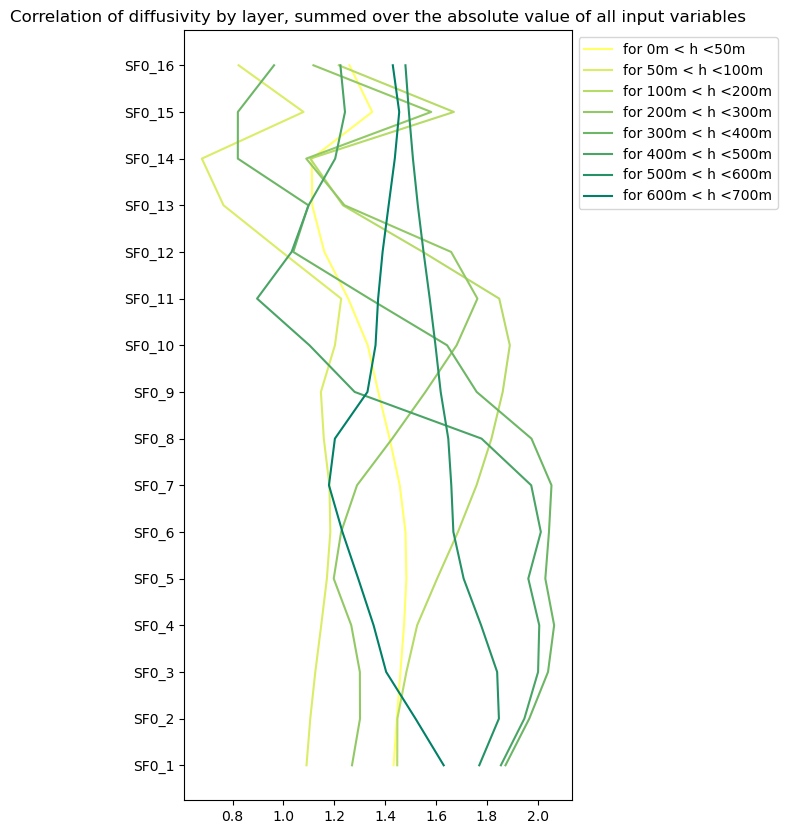

In [85]:
plt.figure(figsize=(5,10))
plt.plot(corr_0_50_prof,    y, label=f"for 0m < h <50m",  color=colors[0])
plt.plot(corr_50_100_prof,  y, label=f"for 50m < h <100m",  color=colors[1])
plt.plot(corr_100_200_prof, y, label=f"for 100m < h <200m",  color=colors[2])
plt.plot(corr_200_300_prof, y, label=f"for 200m < h <300m", color=colors[3])
plt.plot(corr_300_400_prof, y, label=f"for 300m < h <400m", color=colors[4])
plt.plot(corr_400_500_prof, y, label=f"for 400m < h <500m", color=colors[5])
plt.plot(corr_500_600_prof, y, label=f"for 500m < h <600m", color=colors[6])
plt.plot(corr_600_700_prof, y, label=f"for 600m < h <700m", color=colors[7])
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=[1,1])
plt.yticks(ticks=np.arange(1,17,1),labels=['SF0_1','SF0_2','SF0_3','SF0_4','SF0_5','SF0_6','SF0_7','SF0_8','SF0_9','SF0_10','SF0_11','SF0_12','SF0_13','SF0_14','SF0_15','SF0_16']);
plt.title('Correlation of diffusivity by layer, summed over the absolute value of all input variables')
plt.gca().invert_yaxis()